# Image classification model using CNN and keras 

- Predicts whether an image is a zoomed or a normal image. 
- This model was used to remove the zoomed images from our **_Atlas_** dataset.

## 1. Setup

### 1.1 Install the necessary packages

- Create virtual environment 
    - conda create --name atlas python=3.6
- Install the required packages
    - pip install tensorflow==1.5
    - pip install keras --upgrade
    - pip install scikit-learn
    - pip install pandas
    - pip install ipykernel
    - sudo env PATH=$PATH python -m ipykernel install --name atlas

### 1.2 Import packages and libraries

In [12]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from zoomed_vs_normal import *

## 2. Extract the Dataset

We provide a JSON file,  *`zvsn_data.json`*  located in  *`Atlas/dataset/`*  directory which has the URL's of the images and their labels. 

A sample record from the JSON shown below:

```
{'filename': 'af9882e41bb9eb964a32815bc1f5085778a4d7e2.jpg', 
'image_url': 'http://rukmini1.flixcart.com/image/300/300/jepzrm80/shirt/2/t/v/xl-spidershirt-2-tribewear-original-imaf3bvnte6fvv5y.jpeg?q=100', 
'label': 'zoomed', 
'title': "Tribewear Men's Geometric Print Casual White Shirt"}
```

Switch to the `Atlas/dataset/` directory and run the script to extract the images

```
cd ../../dataset
python create_dataset.py -m zvsn
```

The images will be downloaded and present in the `Atlas/dataset/` directory

## 3. Classification Model - Zoomed VS Normal

### 3.1 Create the dataset

Reading images from folder and preparing the dataset

In [4]:
img_width, img_height = 150, 150
X,y = prepare_data("../../dataset/Normal_vs_Zoomed", 150, 150)
X[:1].shape

Getting the images from the data folder
2 classes were found:['Normal' 'Zoomed']
Total number of images in the dataset: 8824
Dimensions of images in the dataset: (150, 150, 3)


(1, 150, 150, 3)

### 3.2 Split the dataset into train, test and validation sets

In [5]:
from sklearn.model_selection import train_test_split

#Splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=33)
print("Train set size: {0}, Val set size: {1}, Test set size: {2}".format(len(X_train), len(X_val), len(X_test)))

Train set size: 7059, Val set size: 883, Test set size: 882


### 3.3 Image Preprocessing

In [6]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [7]:
datagen.fit(X_train)

### 3.4 Creating a preview folder to view preprocessed images 

In [9]:
!rm -r preview
!mkdir preview

i = 0
for batch in datagen.flow(X[:1], batch_size=1,
                          save_to_dir='preview', save_prefix='test', save_format='jpeg'):
    i += 1
    if i > 5:
        break  # otherwise the generator would loop indefinitely

!ls preview/

test_0_2624.jpeg  test_0_6979.jpeg  test_0_7405.jpeg
test_0_4847.jpeg  test_0_7175.jpeg  test_0_7604.jpeg


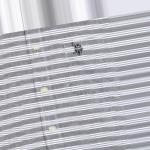

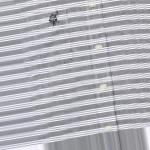

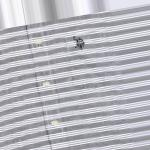

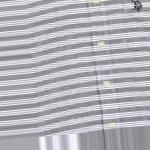

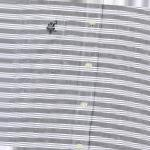

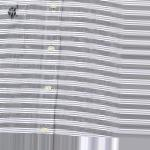

In [12]:
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

modified_images = glob.glob('preview/*jpeg')
for img in modified_images:
    display(_Imgdis(filename=img))

### 3.5 Build the model

In [ ]:
# get model definition
model = zvsn_model()

### 3.6 Train the Model

In [ ]:
# train model
model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch=len(X_train) / 128, validation_data=(X_val,y_val), epochs=10,verbose=2)

In [ ]:
# save model
model.save('zoomed_vs_normal.h5')

### 3.7 Loading the model and applying it on test data

In [13]:
from keras.models import load_model
model = load_model('zoomed_vs_normal.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_2 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [14]:
# get predictions for test set
y_test_pred = predict(model, datagen, X_test)

### 3.8 Get model metrics

In [15]:
# get classification metrics 
print_metrics(y_test, y_test_pred)

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       732
          1       0.97      0.97      0.97       150

avg / total       0.99      0.99      0.99       882



In [16]:
datagen.mean, datagen.std

(array([[[ 27.0417099,  27.0417099,  27.0417099]]], dtype=float32),
 array([[[ 83.20262909,  83.20262909,  83.20262909]]], dtype=float32))

## 4. Predict on other dataset
### 4.1 Load model and get predictions

In [13]:
# load model
from keras.models import load_model
model = load_model('zoomed_vs_normal.h5')

In [14]:
import numpy as np
def preprocess(X):
    mean = np.array([27.04171, 27.04171, 27.04171]).reshape(1,1,3)
    std = np.array([83.20263, 83.20263, 83.20263]).reshape(1,1,3)
    X -= mean
    X /= (std + K.epsilon())
    return X    

In [15]:
# preprocess images from other dataset
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess)
sample_images = test_datagen.flow_from_directory("../../dataset/zvsn_test/",
                                              target_size=(150,150),
                                              class_mode=None,
                                              shuffle=False)

Found 12 images belonging to 1 classes.


In [16]:
%%time
# get predictions
predictions = model.predict_generator(sample_images)

CPU times: user 1.06 s, sys: 593 ms, total: 1.65 s
Wall time: 1.31 s


### 4.2 Transform predictions into a dataframe

In [18]:
import pandas as pd
pred_df = pd.DataFrame({'filenames':sample_images.filenames,'predictions':predictions.ravel()})
pred_df['label'] = (pred_df.predictions > 0.5).astype(int)
pd.options.display.max_colwidth=-1
pred_df.head()

,filenames,predictions,label
0,test/00a0af2c5db4f4e48f91450c867bb56154aaf871.jpg,9.423085e-01,1
1,test/00b2cbb855a9effaa2ac21bd5330593353b24c29.jpg,9.710905e-01,1
2,test/0a0f2d306960acb75272d1fb8e89a6167eb2bf38.jpg,7.599932e-11,0
3,test/0a205b61d6172b91baec939c7a904538733ffe5d.jpg,9.776813e-01,1
4,test/0a3c44db7e041dbb6ebc9a78525a1afe81f281a4.jpg,2.457989e-11,0


### 4.3 View images that are predicted by the model

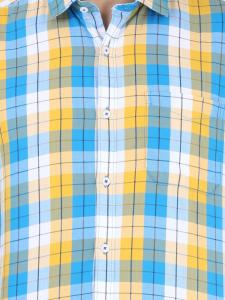

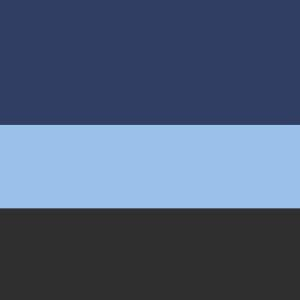

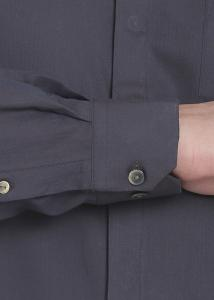

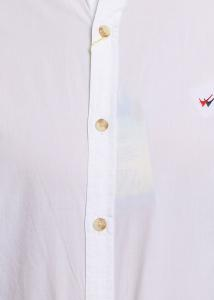

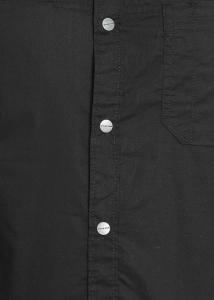

In [20]:
# view images that are predicted as zoomed by the model
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

for img in pred_df[pred_df.label==1].sample(frac=1.0).head().iterrows():
    display(_Imgdis(filename='../../dataset/zvsn_test/'+img[1].filenames))

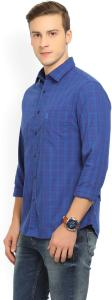

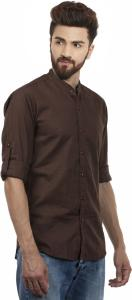

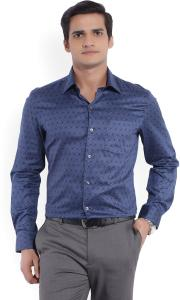

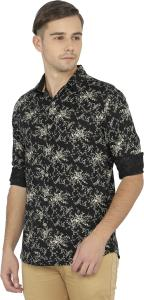

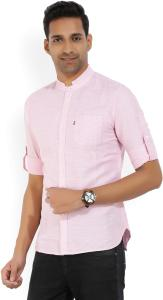

In [21]:
# view images that are predicted as normal by the model
for img in pred_df[pred_df.label==0].sample(frac=1.0).head().iterrows():
    display(_Imgdis(filename='../../dataset/zvsn_test/'+img[1].filenames))

### 4.4 Save images in corresponding folders based on their predictions

In [23]:
# create zoomed and normal folders where the predicted images will be placed
import os 
zoomed_path = '../../dataset/zvsn_test_predicted/zoomed/'
normal_path = '../../dataset/zvsn_test_predicted/normal/'

if not os.path.exists(zoomed_path):
    os.makedirs(zoomed_path)
if not os.path.exists(normal_path):
    os.makedirs(normal_path)

In [34]:
# move normal images to normal_path
import shutil
for img in pred_df[pred_df.label==0].sample(frac=1.0).iterrows():
    file_name = img[1].filenames.split('/')[-1]
    source_location = '../../dataset/zvsn_test/'+ img[1].filenames
    target_location = normal_path + file_name
    shutil.copy(source_location, target_location)

In [35]:
# move zoomed images to zoomed_path
for img in pred_df[pred_df.label==1].sample(frac=1.0).iterrows():
    file_name = img[1].filenames.split('/')[-1]
    source_location = '../../dataset/zvsn_test/'+ img[1].filenames
    target_location = zoomed_path + file_name
    shutil.copy(source_location, target_location)

## References:

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html